In [ ]:
import kagglehub
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Kaggle dataset download
image_paths = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")


100%|██████████| 1.76G/1.76G [00:29<00:00, 64.9MB/s]

Extracting files...


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def prepare_data_recursive(image_dir):
    data = []
    labels = []
    label_map = {}
    current_label_idx = 0

    for root, dirs, files in os.walk(image_dir):
        for subdir in dirs:
            # Exclude invalid classes
            if subdir in ['lung_image_sets', 'colon_image_sets']:
                continue

            # Process valid classes
            if subdir.startswith("colon") or subdir.startswith("lung"):
                if subdir not in label_map:
                    label_map[subdir] = current_label_idx
                    current_label_idx += 1

                class_dir = os.path.join(root, subdir)
                for img_file in os.listdir(class_dir):
                    if img_file.endswith((".jpg", ".png", ".jpeg")):
                        data.append(os.path.join(class_dir, img_file))
                        labels.append(label_map[subdir])

    # Train (80%), Validation (10%), Test (10%) split
    train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

    return train_data, val_data, test_data, train_labels, val_labels, test_labels, label_map


In [ ]:
# Prepare data
dataset_path = os.path.join(image_paths, "lung_colon_image_set")
train_images, val_images, test_images, train_labels, val_labels, test_labels, label_map = prepare_data_recursive(dataset_path)

In [ ]:
# Dataset class with data augmentation
class CancerDataset(Dataset):
    def __init__(self, image_paths, labels, processor, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.augment = augment
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.augment:
            image = self.transform(image)
        label = self.labels[idx]
        inputs = self.processor(images=image, return_tensors="pt")
        return inputs['pixel_values'].squeeze(0), label

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
# Create datasets and dataloaders
batch_size = 32
train_dataset = CancerDataset(train_images, train_labels, processor, augment=True)
val_dataset = CancerDataset(val_images, val_labels, processor)
test_dataset = CancerDataset(test_images, test_labels, processor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Optimizer and loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

In [ ]:
# Prepare text descriptions for each class

# Define the mapping between subdirectory names and cancer types
cancer_types = {
    'colon_aca': 'Colon Adenocarcinoma',
    'colon_n': 'Colon Normal',
    'lung_aca': 'Lung Adenocarcinoma',
    'lung_n': 'Lung Normal',
    'lung_scc': 'Lung Squamous Cell Carcinoma'
}

# Generate textual descriptions for each class based on the mapping
text_descriptions = [f"{cancer_types[class_name]} Histopathology Image" for class_name in label_map.keys()]

print("Text descriptions for classes:")
print(text_descriptions)

Text descriptions for classes:
['Colon Adenocarcinoma Histopathology Image', 'Colon Normal Histopathology Image', 'Lung Adenocarcinoma Histopathology Image', 'Lung Normal Histopathology Image', 'Lung Squamous Cell Carcinoma Histopathology Image']


In [ ]:
# Training and validation loop
num_epochs = 10
best_val_accuracy = 0.0

In [ ]:
print("Classes:", list(label_map.keys()))

Classes: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Extract features
        image_features = model.get_image_features(pixel_values=images)
        text_inputs = processor(text=text_descriptions, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_inputs)

        # Normalize and compute similarity
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        similarity = image_features @ text_features.T

        # Compute loss and update weights
        loss = criterion(similarity, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(similarity, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            image_features = model.get_image_features(pixel_values=images)
            text_features = model.get_text_features(**text_inputs)

            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
            similarity = image_features @ text_features.T
            _, preds = torch.max(similarity, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    val_accuracy = correct_predictions / total_samples
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_clip_model.pth")
        print("Best model saved.")

Epoch 1/10, Loss: 624.9931, Train Accuracy: 0.6916
Validation Accuracy: 0.6960
Best model saved.
Epoch 2/10, Loss: 571.4134, Train Accuracy: 0.8200
Validation Accuracy: 0.8460
Best model saved.
Epoch 3/10, Loss: 548.0479, Train Accuracy: 0.8824
Validation Accuracy: 0.9488
Best model saved.
Epoch 4/10, Loss: 536.2835, Train Accuracy: 0.9012
Validation Accuracy: 0.9360
Epoch 5/10, Loss: 531.9861, Train Accuracy: 0.9105
Validation Accuracy: 0.8396
Epoch 6/10, Loss: 526.5247, Train Accuracy: 0.9191
Validation Accuracy: 0.9644
Best model saved.
Epoch 7/10, Loss: 522.2663, Train Accuracy: 0.9257
Validation Accuracy: 0.9640
Epoch 8/10, Loss: 520.1029, Train Accuracy: 0.9291
Validation Accuracy: 0.9612
Epoch 9/10, Loss: 521.3642, Train Accuracy: 0.9286
Validation Accuracy: 0.9628
Epoch 10/10, Loss: 520.8016, Train Accuracy: 0.9314
Validation Accuracy: 0.9684
Best model saved.


Test Accuracy: 0.9656


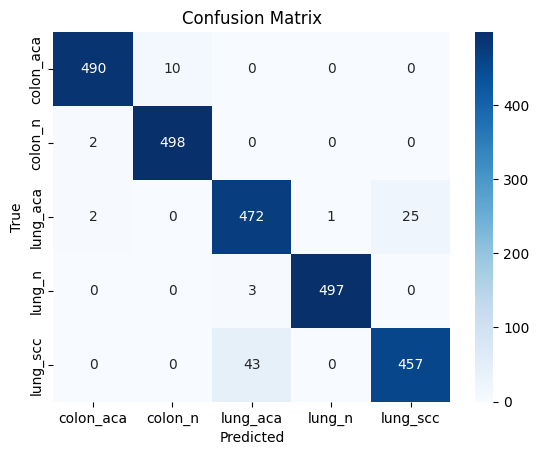

Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.99      0.98      0.99       500
     colon_n       0.98      1.00      0.99       500
    lung_aca       0.91      0.94      0.93       500
      lung_n       1.00      0.99      1.00       500
    lung_scc       0.95      0.91      0.93       500

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



In [ ]:
# Test the model
model.eval()
correct_predictions = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        image_features = model.get_image_features(pixel_values=images)
        text_features = model.get_text_features(**text_inputs)

        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        similarity = image_features @ text_features.T
        _, preds = torch.max(similarity, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

# Ensure the test evaluation includes all classes
all_classes = list(label_map.keys())  # All classes in label_map
class_indices = list(label_map.values())  # Corresponding indices of classes

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=all_classes))
